<a href="https://colab.research.google.com/github/thisismedha/CNN/blob/main/AlexNet_GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import GTSRB
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

#creating a dinstinct transform class for the train, validation and test dataset
transform_train = transforms.Compose([transforms.Resize((227,227)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_test = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = GTSRB(root='./data', split='train',
                 download=True, transform=transform_train)
val_size = 10000 
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = GTSRB(root='./data', split='test',
                      download=True, transform=transform_test)

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

# Data Set
# GTSRB
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

Single-image, multi-class classification problem
More than 40 classes
More than 50,000 images in total
Large, lifelike database

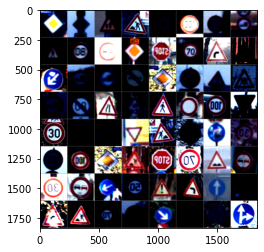

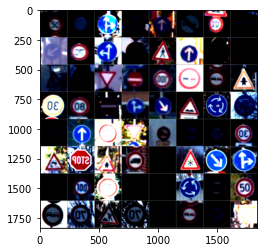

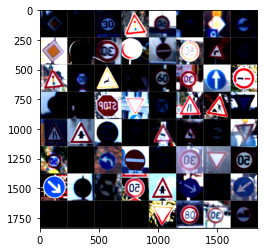

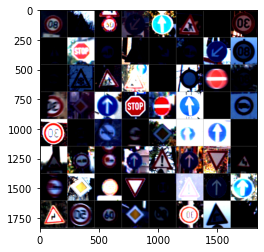

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # move channel dimension to the last dimension
    # plt.imshow(npimg)  # move channel dimension to the last dimension
    plt.show()

# loop through the trainloader to get the batches of data
for i, data in enumerate(train_dl, 0):
    # get the inputs
    inputs, labels = data

    # show images
    imshow(torchvision.utils.make_grid(inputs))

    if i == 3:  # show only 4 batches
        break


In [ ]:
# Define AlexNet
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=43):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

alex_net = AlexNet()


In [ ]:
import torch.optim as optim

# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Select SGD as the optimizer here. There are also other optimizers, such as Adam, RMSprop.
optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
print(torch.cuda.is_available()) # where cuda can be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # set the device

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

False
cpu


In [ ]:
# Train
#alex_net = AlexNet() #to compile the model
#alex_net = alex_net.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

max_epochs = 2  # specify the maximum number of training epoches Here we only train 2 epoches
alex_net.train()
for epoch in range(max_epochs): 
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = alex_net(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(test_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = alex_net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )


print('Finished Training')

Loss in epoch 0 :::: 2.6996818845088666
Got 4453 / 12630 with accuracy 35.26
Loss in epoch 1 :::: 1.229768709723766
Got 7662 / 12630 with accuracy 60.67
Finished Training


In [ ]:
num_correct = 0
num_samples = 0
alex_net.eval()
for batch_idx, (data,targets) in enumerate(test_dl):
    data = data.to(device=device)
    targets = targets.to(device=device)
    ## Forward Pass
    scores = alex_net(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
)

Got 7866 / 12630 with accuracy 62.28


In [ ]:
# Accuracy is 62.28%